## Q 1

### Part A

In [1]:
import pandas as pd
from scipy.optimize import curve_fit
import numpy as np

# Define the nonlinear model function
def nonlinear_regression_model(bid_value, alpha, beta):
    return alpha * (1 - np.exp(-beta * bid_value))

alpha_beta_estimates = {}
keywords = ['kw8322228', 'kw8322392', 'kw8322393', 'kw8322445']
file_paths = {
    'kw8322228': r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\clicksdata.kw8322228.csv',
    'kw8322392': r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\clicksdata.kw8322392.csv',
    'kw8322393': r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\clicksdata.kw8322393.csv',
    'kw8322445': r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\clicksdata.kw8322445.csv'
}

for keyword in keywords:
    file_path = file_paths[keyword]  
    data = pd.read_csv(file_path)
    popt, _ = curve_fit(nonlinear_regression_model, data['bid.value'], data['n.clicks'], p0=[150, 0.5])
    alpha_beta_estimates[keyword] = popt

alpha_beta_estimates

{'kw8322228': array([7.40912018e+01, 3.94487110e-02]),
 'kw8322392': array([1.56440013e+02, 1.50082487e-01]),
 'kw8322393': array([1.04799344e+02, 7.97165197e-02]),
 'kw8322445': array([188.11195908,   0.43228912])}

### Part B

In [2]:
from scipy.optimize import minimize

# LTV and Conversion Rate values for each keyword
ltv_conv = {
    'kw8322228': {'ltv': 354, 'conv_rate': 0.3},
    'kw8322392': {'ltv': 181, 'conv_rate': 0.32},
    'kw8322393': {'ltv': 283, 'conv_rate': 0.3},
    'kw8322445': {'ltv': 107, 'conv_rate': 0.3}
}

# Function to calculate profit
def calculate_profit(bid, alpha, beta, ltv, conv_rate):
    clicks = alpha * (1 - np.exp(-beta * bid))
    return -(clicks * conv_rate * ltv - clicks * bid)  # Negative for minimization

# Optimal bids
optimal_bids = {}

for keyword, params in alpha_beta_estimates.items():
    alpha, beta = params
    ltv = ltv_conv[keyword]['ltv']
    conv_rate = ltv_conv[keyword]['conv_rate']
    result = minimize(calculate_profit, x0=1, args=(alpha, beta, ltv, conv_rate), bounds=[(0, None)])
    optimal_bids[keyword] = result.x[0]

#Print optimal bids
optimal_bids

{'kw8322228': 34.1277168882183,
 'kw8322392': 13.56346467586668,
 'kw8322393': 22.433879101644955,
 'kw8322445': 5.81697735455261}

### Part C

In [3]:
from scipy.optimize import minimize

# Objective function for total profit considering all keywords
def total_profit(bids):
    total_profit = 0
    for i, keyword in enumerate(keywords):
        alpha, beta = alpha_beta_estimates[keyword]
        ltv = ltv_conv[keyword]['ltv']
        conv_rate = ltv_conv[keyword]['conv_rate']
        bid = bids[i]
        clicks = alpha * (1 - np.exp(-beta * bid))
        total_profit += clicks * conv_rate * ltv - clicks * bid
    return -total_profit  # Negative for maximization

# Budget constraint
def budget_constraint(bids):
    total_budget = 3000
    total_expenditure = sum(bids)
    return total_budget - total_expenditure

# Constraint dictionary
cons = ({'type': 'ineq', 'fun': budget_constraint})

# Initial bid guesses
initial_bids = [10, 10, 10, 10]  

# Perform the constrained optimization
budget_constrained_result = minimize(total_profit, x0=initial_bids, constraints=cons, bounds=[(0, None)] * 4)

budget_constrained_result.x  # Optimal bids under budget constraint

array([34.12778543, 13.56349459, 22.43389095,  5.81697001])

## Q 2

In [4]:
import pandas as pd
from scipy.stats import beta
import numpy as np

# Load clicks data
data = pd.read_excel(r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\clicks.dataset.2.xlsx')

In [5]:
data

,ad,1,2,3,4,5
0,clicks,52,38,51,45,25
1,exposures,1000,1000,1000,1000,1000


In [6]:
clicks_data = pd.DataFrame(data)

# Transposing the DataFrame to get campaigns as rows
clicks_data = clicks_data.set_index('ad').T

# Now calculating the posterior parameters for CTR
clicks_data['alpha'] = clicks_data['clicks'] + 1
clicks_data['beta'] = clicks_data['exposures'] - clicks_data['clicks'] + 1

In [8]:
# Number of simulations
n_simulations = 100000

# Simulate draws and calculate the highest CTR probability
highest_ctr_prob = np.zeros(len(clicks_data))
for i in range(n_simulations):
    draws = beta.rvs(a=clicks_data['alpha'], b=clicks_data['beta'])
    highest_ctr_prob[np.argmax(draws)] += 1

highest_ctr_prob /= n_simulations

In [9]:
highest_ctr_prob

array([4.7157e-01, 1.6920e-02, 3.9359e-01, 1.1790e-01, 2.0000e-05])

In [10]:
n_simulations

100000

In [11]:
import pandas as pd
from scipy.stats import t
import numpy as np

# Load volumes data
volumes_data = pd.read_excel(r'C:\Users\Rohit Srivastava\OneDrive\Desktop\ISB\Sixth Term\Assignments\MA\Individual Assignments\3\volumes.dataset.2.xlsx')

volumes_data

,cust,ad,volume
0,1,1,32
1,2,1,54
2,3,1,31
3,4,1,24
4,5,1,42
...,...,...,...
206,207,5,47
207,208,5,61
208,209,5,63
209,210,5,102


In [12]:
from scipy.stats import t, beta
import numpy as np

# Group by ad campaign and calculate statistics
grouped = volumes_data.groupby('ad')['volume']
means = grouped.mean()
std_errs = grouped.sem()
dfs = grouped.count() - 1

# Number of simulations
n_simulations = 100000

In [13]:
means

ad
1    42.076923
2    57.289474
3    41.803922
4    47.888889
5    90.640000
Name: volume, dtype: float64

In [14]:
std_errs

ad
1    1.391324
2    2.822110
3    1.945134
4    2.017655
5    6.137285
Name: volume, dtype: float64

In [15]:
dfs

ad
1    51
2    37
3    50
4    44
5    24
Name: volume, dtype: int64

In [16]:
# Task 2: Calculate the highest average post-click volume probability
highest_volume_prob = np.zeros(len(means))
for i in range(n_simulations):
    draws = t.rvs(df=dfs, loc=means, scale=std_errs)
    highest_volume_prob[np.argmax(draws)] += 1
highest_volume_prob /= n_simulations

In [17]:
highest_volume_prob

array([0.0000e+00, 1.0000e-05, 0.0000e+00, 0.0000e+00, 9.9999e-01])

In [18]:
# Number of simulations
n_simulations = 100000

In [20]:
# Initialize array for highest EVI probability
highest_evi_prob = np.zeros(len(clicks_data))

# Calculate the highest EVI probability
for i in range(n_simulations):
    # Draw from CTR and post-click volume distributions
    ctr_draws = beta.rvs(a=clicks_data['alpha'], b=clicks_data['beta'])
    volume_draws = t.rvs(df=dfs, loc=means, scale=std_errs)
    
    # Calculate EVI for each campaign
    evi_draws = ctr_draws * volume_draws
    
    # Determine which campaign has the highest EVI in this draw
    highest_evi_prob[np.argmax(evi_draws)] += 1

# Normalize to get probabilities
highest_evi_prob /= n_simulations

In [21]:
highest_evi_prob

array([0.16753, 0.19762, 0.13133, 0.16117, 0.34235])

## Graphics for report

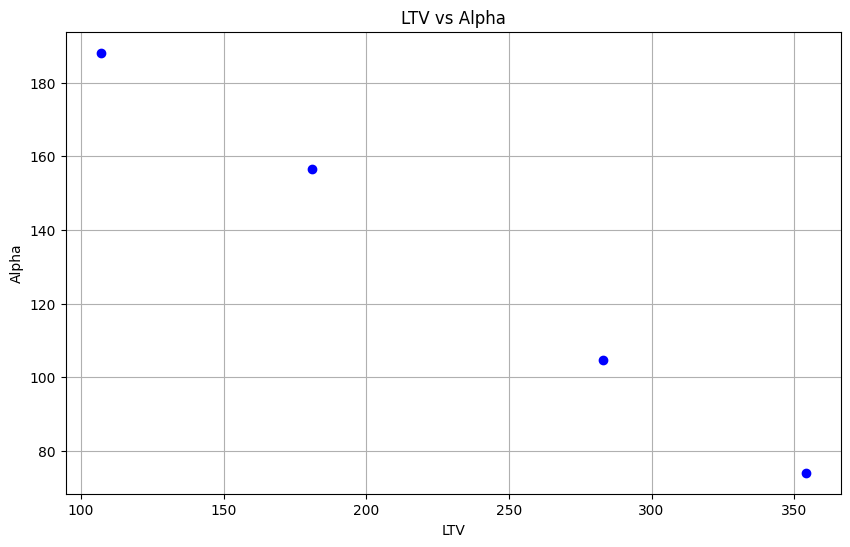

In [22]:
import matplotlib.pyplot as plt

# dictionary with LTV values for each keyword
ltv_values = {'kw8322228': 354, 'kw8322392': 181, 'kw8322393': 283, 'kw8322445': 107}

# Alpha values from the analysis
alpha_values = {'kw8322228': 74.09, 'kw8322392': 156.44, 'kw8322393': 104.79, 'kw8322445': 188.11}

# Creating lists of LTV and alpha values
ltvs = [ltv_values[key] for key in ltv_values]
alphas = [alpha_values[key] for key in alpha_values]

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ltvs, alphas, color='blue')
plt.title('LTV vs Alpha')
plt.xlabel('LTV')
plt.ylabel('Alpha')
plt.grid(True)
plt.show()

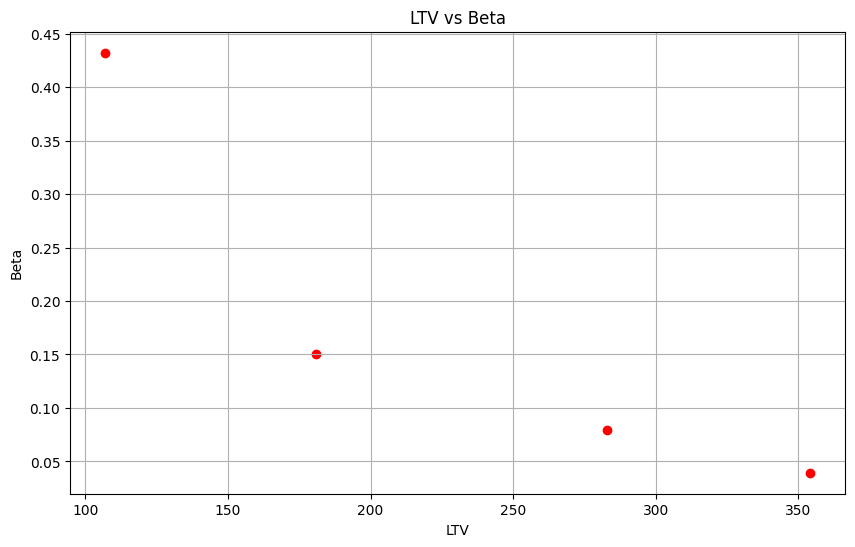

In [23]:
# Beta values from the analysis
beta_values = {'kw8322228': 0.0394, 'kw8322392': 0.1501, 'kw8322393': 0.0797, 'kw8322445': 0.4323}

# Creating a list of beta values
betas = [beta_values[key] for key in beta_values]

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ltvs, betas, color='red')
plt.title('LTV vs Beta')
plt.xlabel('LTV')
plt.ylabel('Beta')
plt.grid(True)
plt.show()

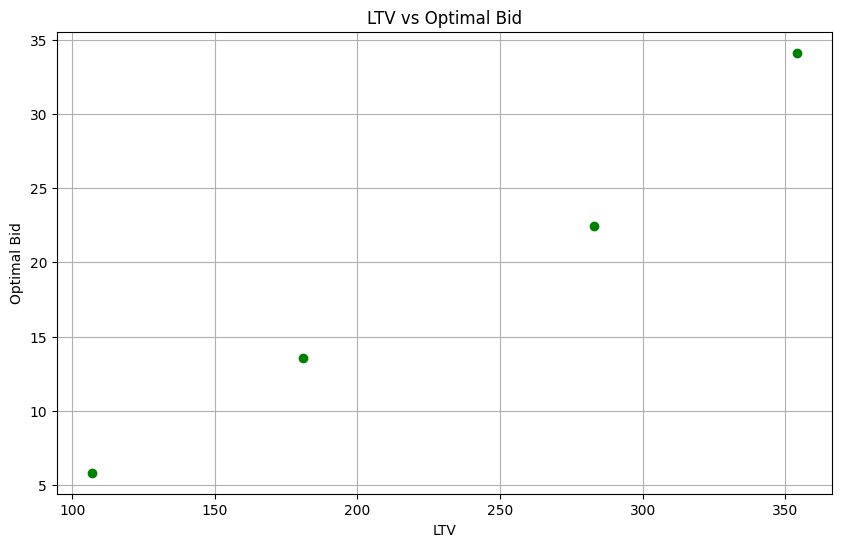

In [24]:
# Optimal bid values from our analysis
optimal_bids = {'kw8322228': 34.13, 'kw8322392': 13.56, 'kw8322393': 22.43, 'kw8322445': 5.82}

# Creating a list of optimal bid values
bids = [optimal_bids[key] for key in optimal_bids]

# Creating the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ltvs, bids, color='green')
plt.title('LTV vs Optimal Bid')
plt.xlabel('LTV')
plt.ylabel('Optimal Bid')
plt.grid(True)
plt.show()